In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [4]:
def load_ds(img):
    col_path = tf.strings.join(['./data/color/',img])
    bw_path = tf.strings.join(['./data/gray/',img])
    
    # Read and decode images
    col_img = tf.io.read_file(col_path)
    col_img = tf.image.decode_jpeg(col_img, channels=3)
    col_img = tf.image.resize(col_img, IMG_SIZE) / 255.0

    bw_img = tf.io.read_file(bw_path)
    bw_img = tf.image.decode_jpeg(bw_img, channels=1)
    bw_img = tf.image.resize(bw_img, IMG_SIZE) / 255.0
    
    return bw_img, col_img

In [5]:
filenames = os.listdir('./data/color')
filenames = tf.constant(filenames)

2025-05-06 11:31:00.012602: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-06 11:31:00.012764: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-06 11:31:00.013081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-06 11:31:00.013783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-06 11:31:00.014338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
ds = tf.data.Dataset.from_tensor_slices(filenames)
ds = ds.map(load_ds, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.shuffle(buffer_size=1000, seed=42)

In [7]:
train_size = int(0.8 * len(filenames))
train_ds = ds.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

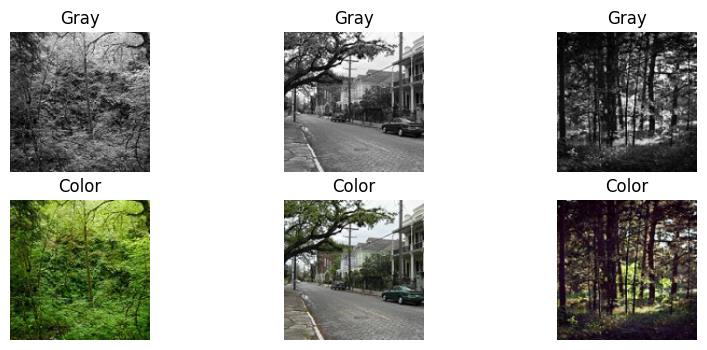

2025-05-06 11:31:37.657767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
#TEST - ds loaded correctly
for bw_img, col_img in test_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(tf.squeeze(bw_img[i]), cmap='gray')
        plt.title("Gray")
        plt.axis('off')
        
        plt.subplot(2, 3, 3 + i + 1)
        plt.imshow(col_img[i])
        plt.title("Color")
        plt.axis('off')
    plt.show()

In [8]:
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(160, 160, 1))

    # ENCODER
    c1 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
    c2 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(c1)
    c3 = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(c2)
    c4 = layers.Conv2D(512, 3, strides=2, padding='same', activation='relu')(c3)

    # DECODER
    ct1 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(c4)
    conc1 = layers.Concatenate()([ct1, c3])

    ct2 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(conc1)
    conc2 = layers.Concatenate()([ct2, c2])

    ct3 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(conc2)
    conc3 = layers.Concatenate()([ct3, c1])

    ct4 = layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')(conc3)

    return models.Model(inputs, ct4)


In [9]:
model = build_model()

In [36]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 80, 80,    │        640 │ input_layer_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 40, 40,    │     73,856 │ conv2d_72[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 20, 20,    │    295,168 │ conv2d_73[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 10, 10,    │  1,180,160 │ conv2d_74[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_30 │ (None, 20, 20,    │  1,179,904 │ conv2d_75[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 20, 20,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_31 │ (None, 40, 40,    │    589,952 │ concatenate_25[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 40, 40,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 80, 80,    │    147,520 │ concatenate_26[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 80, 80,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_72[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_33 │ (None, 160, 160,  │      3,459 │ concatenate_27[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,470,659 (13.24 MB)

 Trainable params: 3,470,659 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss=losses.MeanSquaredError()
             )
EPOCHS=10

In [11]:
hist = model.fit(train_ds,validation_data=test_ds,epochs=EPOCHS)

Epoch 1/10


2025-04-29 12:34:04.636559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - loss: 0.0387 - val_loss: 0.0114
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - loss: 0.0058 - val_loss: 0.0060


In [14]:
total_loss = 0.0
batch_count = 0

for bw_imgs, col_imgs in test_ds:
    predictions = model(bw_imgs, training=False)

    loss = losses.MeanSquaredError()(col_imgs, predictions)
    total_loss += loss.numpy()
    batch_count+=1

aver_loss = total_loss / batch_count
print(f'Total test loss: {aver_loss:.3f}')

Total test loss: 0.006


2025-04-29 12:56:21.208084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
def display_pred(col_imgs, bw_imgs, preds, num_imgs):
    fig, ax = plt.subplots(num_imgs, 3, figsize=(15, num_imgs*3))

    for i in range(num_imgs):
        ax[i,0].imshow(bw_imgs[i].numpy().squeeze(),cmap='gray')
        ax[i,0].set_title(f'Greyscale {i+1}')
        ax[i,0].axis('off')

        ax[i,1].imshow(col_imgs[i].numpy())
        ax[i,1].set_title(f'Corresponding-coloured from dataset {i+1}')
        ax[i,1].axis('off')

        ax[i,2].imshow(preds[i].numpy())
        ax[i,2].set_title(f'Generated {i+1}')
        ax[i,2].axis('off')

In [32]:
bw_imgs, col_imgs = next(iter(test_ds))#retrieve random batch of data

In [33]:
preds = model(bw_imgs, training=False)

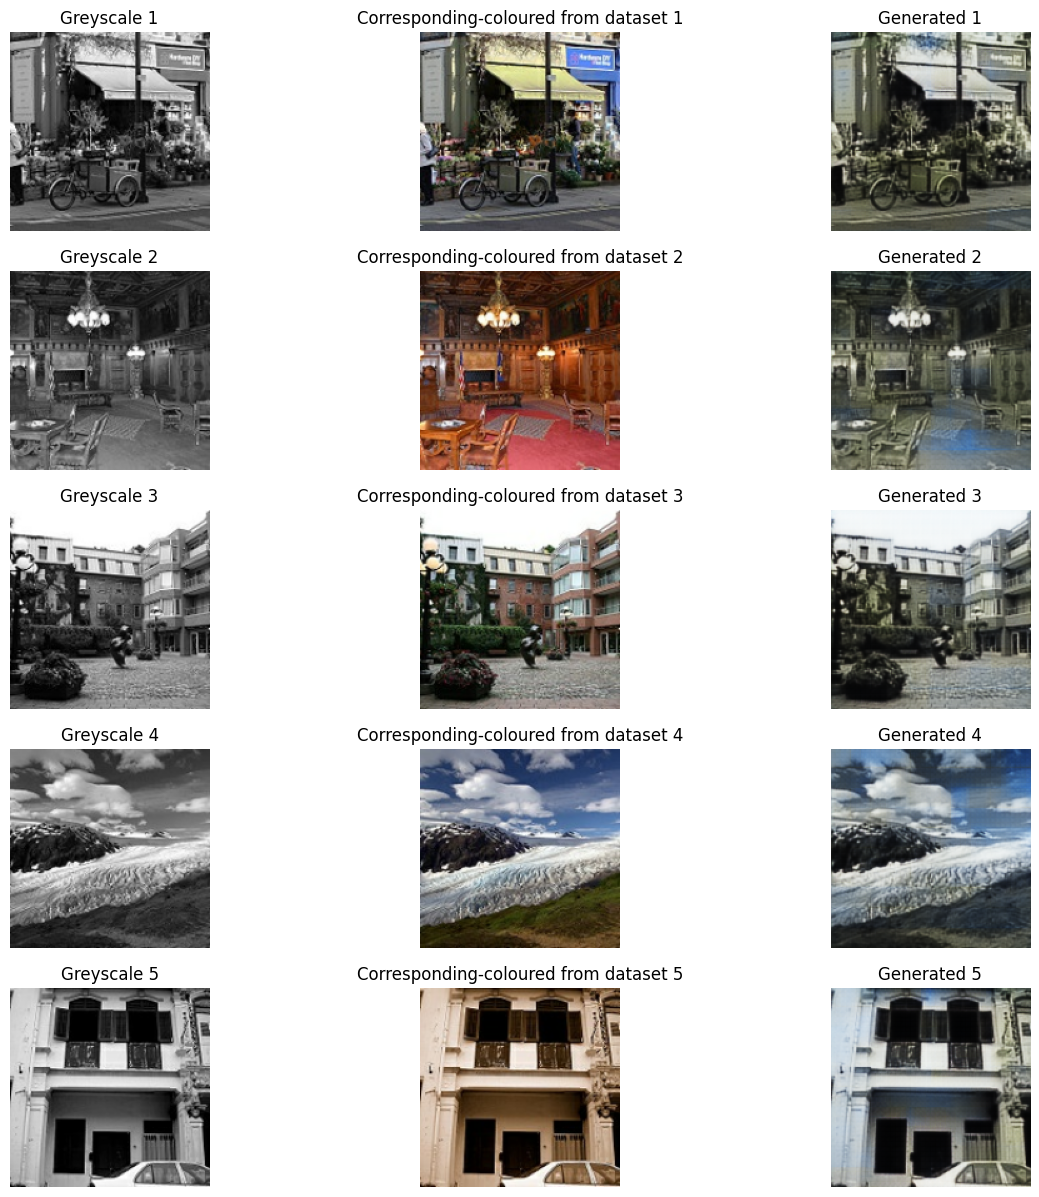

In [34]:
display_pred(col_imgs,bw_imgs,preds,5)

In [37]:
model.save('Saved_Model/trained_model.h5')
print("model saved")

In [24]:
#LOADING PRE-TRAINED MODEL

model = tf.keras.models.load_model('Saved_Model/trained_model.h5')
print("model loaded")

model loaded
